In [18]:
import cv2
import matplotlib.pyplot as plt

camera_index = 0


In [19]:
import cv2, queue, threading, time

# bufferless VideoCapture
class VideoCapture:

  def __init__(self, name):
    self.cap = cv2.VideoCapture(name)
    self.q = queue.Queue()
    t = threading.Thread(target=self._reader)
    t.daemon = True
    t.start()

  # read frames as soon as they are available, keeping only most recent one
  def _reader(self):
    while True:
      ret, frame = self.cap.read()
      if not ret:
        break
      if not self.q.empty():
        try:
          self.q.get_nowait()   # discard previous (unprocessed) frame
        except queue.Empty:
          pass
      self.q.put(frame)

  def read(self):
    return True, self.q.get()

cap = VideoCapture(0)


#### patterns

In [20]:
# import cv2
# import numpy as np
import matplotlib.pyplot as plt

# # Define the dictionary we want to use
# aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

# # Generate a marker
# marker_id = 42
# marker_size = 500  # Size in pixels
# marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)

# cv2.imwrite(f'marker_{marker_id}.png', marker_image)
# plt.imshow(marker_image, cmap='gray', interpolation='nearest')
# plt.axis('off')  # Hide axes
# plt.title(f'ArUco Marker {marker_id}')
# plt.show()


# import cv2
# import numpy as np

# # Generate a black-and-white checkerboard pattern
# def create_checkerboard(square_size, rows, cols):
#     checkerboard = np.zeros((rows * square_size, cols * square_size), dtype=np.uint8)
#     for i in range(rows):
#         for j in range(cols):
#             if (i + j) % 2 == 0:
#                 cv2.rectangle(
#                     checkerboard,
#                     (j * square_size, i * square_size),
#                     ((j + 1) * square_size, (i + 1) * square_size),
#                     255,  # White square
#                     -1
#                 )
#     return checkerboard

# # Parameters
# square_size = 50  # Size of each square in pixels
# rows, cols = 6, 8  # Number of squares (rows x cols)

# # Create and save the checkerboard pattern
# checkerboard = create_checkerboard(square_size, rows, cols)
# cv2.imwrite("checkerboard_pattern.jpg", checkerboard)

# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters
# rows, cols = 8, 8  # Number of rows and columns
# square_size = 50   # Size of each square in pixels

# # Create an empty pattern
# pattern = np.zeros((rows * square_size, cols * square_size, 3), dtype=np.uint8)

# # Define colors for the checkerboard
# colors = [
#     (255, 0, 0),  # Red
#     (0, 255, 0),  # Green
#     (0, 0, 255),  # Blue
#     (255, 255, 0) # Yellow
# ]

# # Create the checkerboard pattern
# for i in range(rows):
#     for j in range(cols):
#         color = colors[(i + j) % len(colors)]
#         cv2.rectangle(
#             pattern,
#             (j * square_size, i * square_size),
#             ((j + 1) * square_size, (i + 1) * square_size),
#             color,
#             -1
#         )

# # Save or display the pattern
# cv2.imwrite("colorful_pattern.jpg", pattern)

# plt.imshow(pattern)


#### pygame

In [21]:
#  load "D:\Users\danny\Downloads\my_pattern.png" as pattern

# # Load the pattern
pattern = cv2.imread(r"D:\Users\danny\Downloads\my_pattern3.png")

In [22]:
import pygame 
import os
pygame.init()
# Load the image

# Get available display info
display_info = pygame.display.get_desktop_sizes()
if len(display_info) < 2:
    print("Only one display detected. Cannot switch to a secondary screen.")
    sys.exit()

# Choose the secondary screen
secondary_screen_index = 0  # Index 1 corresponds to the second screen
secondary_screen_width, secondary_screen_height = display_info[secondary_screen_index]
# Set the environment variable to position the window on the secondary screen
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{display_info[0][0]},{0}"  # Position at the start of the second screen

x = 0
y = 0
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{x},{y}"

# Create a window with the secondary screen resolution


In [23]:
screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (100, 100))  # Draw the surface onto the screen
pygame.display.flip()  # Update the display

True


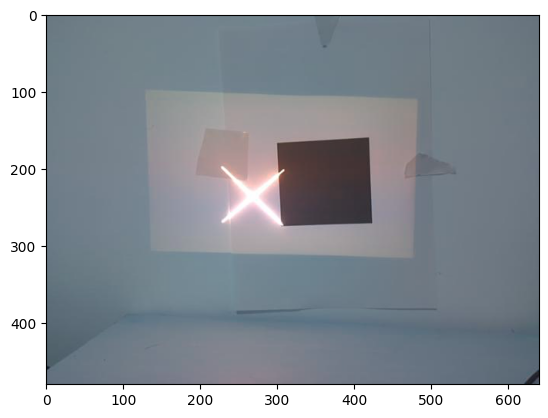

In [24]:

ret, frame = cap.read()
print(ret)

plt.imshow(frame)

In [25]:
import cv2
import numpy as np

# Resizes a image and maintains aspect ratio
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the 0idth and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

global_scale = None 
def find_pattern(pattern, frame, canny=True):
    template = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
    template = cv2.Canny(template, 50, 200)
    (tH, tW) = template.shape[:2]

    # Load original image, convert to grayscale
    original_image = frame
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    found = None

    # Dynamically rescale image for better template matching
    for scale in np.linspace(0.1, 3.0, 20)[::-1]:

        # Resize image to scale and keep track of ratio
        resized = maintain_aspect_ratio_resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        
        # Stop if template image size is larger than resized image
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break

        # Detect edges in resized image and apply template matching
        if canny:
            ref = cv2.Canny(resized, 50, 200)
        else:
            ref = resized
        detected = cv2.matchTemplate(ref, template, cv2.TM_CCOEFF)
        (_, max_val, _, max_loc) = cv2.minMaxLoc(detected)

        # Uncomment this section for visualization
        '''
        clone = np.dstack([canny, canny, canny])
        cv2.rectangle(clone, (max_loc[0], max_loc[1]), (max_loc[0] + tW, max_loc[1] + tH), (0,255,0), 2)
        cv2.imshow('visualize', clone)
        cv2.waitKey(0)
        '''

        # Keep track of correlation value
        # Higher correlation means better match
        if found is None or max_val > found[0]:
            found = (max_val, max_loc, r)

    # Compute coordinates of bounding box
    (_, max_loc, r) = found
    (start_x, start_y) = (int(max_loc[0] * r), int(max_loc[1] * r))
    (end_x, end_y) = (int((max_loc[0] + tW) * r), int((max_loc[1] + tH) * r))
    return (start_x, start_y, end_x, end_y), (max_val,r)

import cv2 
import numpy as np 
 
# Load the image 

def find_rectangle(image): 
    # Convert to grayscale 

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Preprocess the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges
    plt.imshow(edges)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Threshold to determine "black enough"
    black_threshold = 150  # Adjust based on your needs (0 = black, 255 = white)

    # Detect rectangles
    rectangles = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # print(len(approx))
        # Check if it has 4 sides
        if len(approx) == 4 and cv2.isContourConvex(approx):
            # Create a mask for the rectangle
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [approx], -1, 255, -1)
            
            
            # Calculate the mean intensity inside the rectangle
            mean_intensity = cv2.mean(gray, mask=mask)[0]
            print(mean_intensity)
            # Check if the rectangle is "black enough"
            if mean_intensity < black_threshold: 
                start_x, start_y, end_x, end_y = approx[0][0][0], approx[0][0][1], approx[2][0][0], approx[2][0][1]    
                rectangles.append((start_x, start_y, end_x, end_y))
                cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
                
    # return largest rectangle
    if len(rectangles) == 0:
        return None
    return max(rectangles, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))


In [26]:
global_scale

In [27]:
# pattern = cv2.imread(r"D:\git\wall_alignment\checkerboard_pattern.jpg")
pattern = cv2.imread(r"D:\Users\danny\Downloads\my_pattern3.png")


In [28]:
import pygame
import time

def proj_cap_clear(template=False, pos=(100,100)):
    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)
    if template:        
        image_surface = pygame.surfarray.make_surface(pattern)
        screen.blit(image_surface, pos)  # Draw the surface onto the screen
        pygame.display.flip()  # Update the display

    for i in range(10):
        ret, frame = cap.read()

    return (frame)


60.11764705882353
55.200337216431635


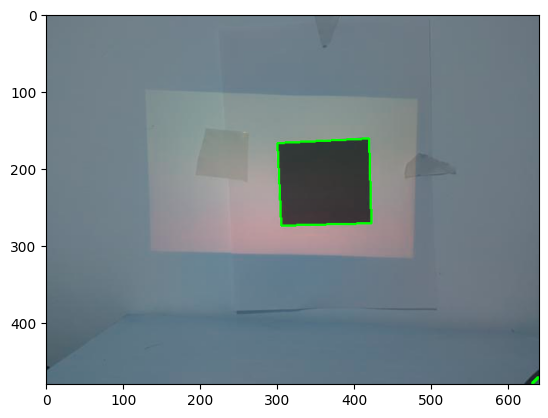

In [29]:
import copy
init_pos = [100, 100]
frame = proj_cap_clear()
(start_x, start_y, end_x, end_y) = find_rectangle(frame)#find_pattern(pattern*0, frame, canny=False)
plt.imshow(frame)

(639, 471, 631, 478)


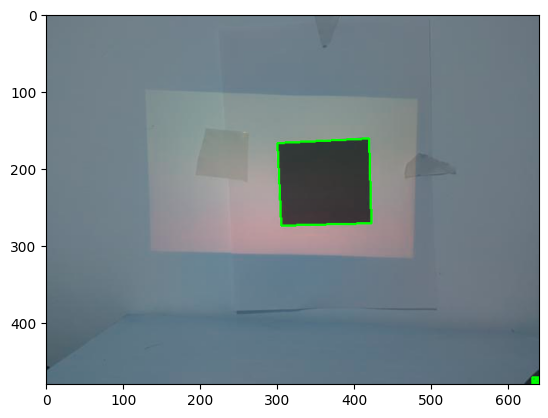

In [30]:
print((start_x, start_y, end_x, end_y))
cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(frame)

[803.5, 523.5]
0.5 10.5
1 21
7364611.0 0.3333333333333333


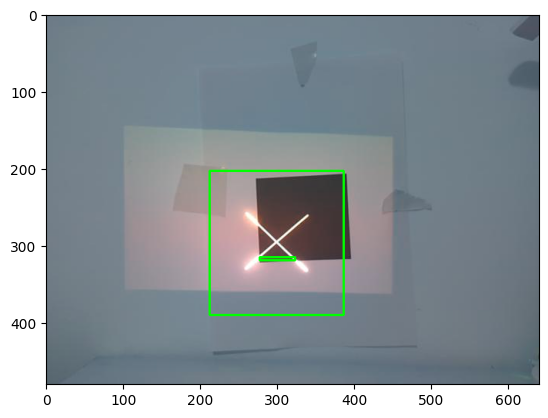

79.79268292682927


KeyboardInterrupt: 

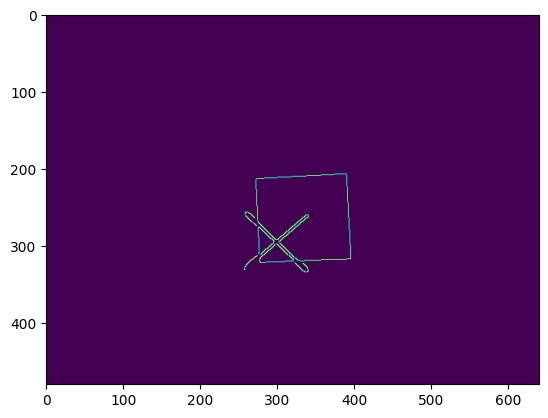

In [31]:
from IPython.display import clear_output
import copy

init_pos = [100, 100]
 #init_pos

x_correct_post = None
y_correct_post = None

max_step = 50
pos = copy.deepcopy(init_pos)
for i in range(10000):

    try:
        (start_x, start_y, end_x, end_y) = find_rectangle(frame)
    except:
        time.sleep(1)
        frame = proj_cap_clear()
        (start_x, start_y, end_x, end_y) = find_rectangle(frame)
        
    frame = proj_cap_clear(template=True, pos=pos)
    orig_frame = copy.deepcopy(frame)
    # frame[start_y:end_y, start_x:end_x] = 0
    (start_x2, start_y2, end_x2, end_y2), (max_val, r) = find_pattern(pattern, frame)
    if max_val < 1000000:
        pos = copy.deepcopy(init_pos)
        print("pattern not found, resetting")
        max_step = int(max_step // 2)
        continue
    # print((start_x2, start_y2, end_x2, end_y2))
    x2_center = (start_x2 + end_x2) // 2
    x_center = (start_x + end_x) // 2
    y2_center = (start_y2 + end_y2) // 2
    y_center = (start_y + end_y) // 2

    x_dist = abs(x2_center - x_center)
    y_dist = abs(y2_center - y_center)

    scale = 0.5

    if x_dist == 0:
        x_correct_post = pos[0]
    if y_dist == 0:
        y_correct_post = pos[1]

    if x_correct_post is not None and y_correct_post is not None:
        pass

    x_step = min(x_dist * scale, max_step)
    y_step = min(y_dist * scale, max_step)

    if True:#x_correct_post is None:
        if  x2_center < x_center: 
            pos[0] += x_step
        elif x2_center > x_center:
            pos[0] -= x_step
    
    if True:#y_correct_post is None:
        if  y2_center < y_center:
            pos[1] += y_step
        elif y2_center > y_center:
            pos[1] -= y_step

    # print(pos)
    # plot frame with rectangle 
    clear_output()
    print(pos)
    print(x_step, y_step)
    print(x_dist, y_dist)
    print(max_val,r)
    cv2.rectangle(orig_frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    cv2.rectangle(orig_frame, (start_x2, start_y2), (end_x2, end_y2), (0, 255, 0), 2)
    plt.imshow(orig_frame)
    plt.show()

    
# scale = 6 
# pos = (pos[0] + (start_x - start_x2 )*scale , pos[1] + (start_y2 - start_y)*scale )



In [21]:
init_pos

[1849, 1141]

In [ ]:
print(pos)
proj_cap_clear(template=True, pos=pos)

[1800, 1060]


array([[[122, 132, 142],
        [122, 132, 142],
        [122, 132, 142],
        ...,
        [115, 125, 133],
        [115, 125, 133],
        [115, 125, 133]],

       [[122, 132, 142],
        [122, 132, 142],
        [122, 132, 142],
        ...,
        [115, 125, 133],
        [115, 125, 133],
        [115, 125, 133]],

       [[122, 132, 142],
        [122, 132, 142],
        [122, 132, 142],
        ...,
        [115, 125, 133],
        [115, 125, 133],
        [115, 125, 133]],

       ...,

       [[106, 119, 133],
        [106, 119, 133],
        [106, 119, 133],
        ...,
        [ 95, 105, 115],
        [ 95, 105, 115],
        [ 95, 105, 115]],

       [[106, 119, 133],
        [106, 119, 133],
        [106, 119, 133],
        ...,
        [ 95, 105, 115],
        [ 95, 105, 115],
        [ 95, 105, 115]],

       [[106, 119, 133],
        [106, 119, 133],
        [106, 119, 133],
        ...,
        [ 95, 105, 115],
        [ 95, 105, 115],
        [ 95, 105, 115]]

120.5
88.79756097560976


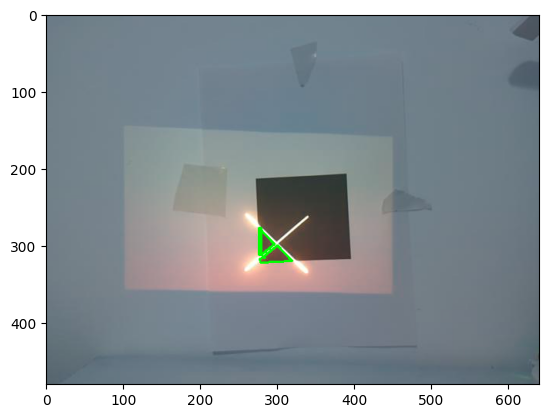

In [33]:
(start_x, start_y, end_x, end_y) = find_rectangle(frame)
orig_frame = copy.deepcopy(frame)
cv2.rectangle(orig_frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(orig_frame)

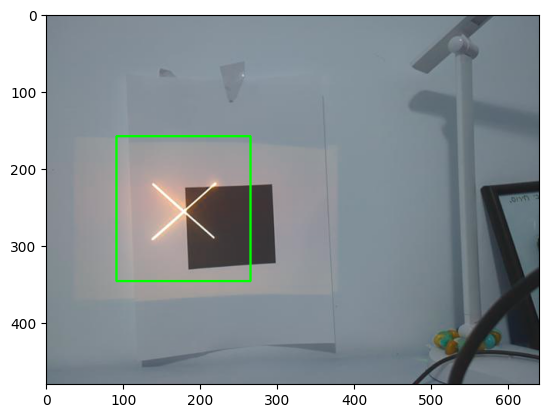

In [ ]:
frame = proj_cap_clear(template=True, pos=pos)

(start_x2, start_y2, end_x2, end_y2), (max_val, r) = find_pattern(pattern, frame)
orig_frame = copy.deepcopy(frame)
cv2.rectangle(orig_frame, (start_x2, start_y2), (end_x2, end_y2), (0, 255, 0), 2)
plt.imshow(orig_frame)


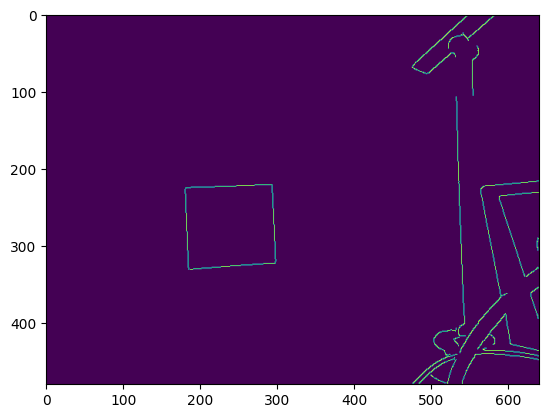

In [ ]:
find_rectangle(frame)

In [32]:
max_val

1467035.0

In [ ]:
end_x - start_x

In [ ]:
pos

In [346]:
frame = proj_cap_clear(template=True, pos=(1400,0))
orig_frame = copy.deepcopy(frame)
frame[start_y:end_y, start_x:end_x] = 0
(start_x2, start_y2, end_x2, end_y2) = find_pattern(pattern, frame)


In [ ]:
start_x - start_x2 

In [332]:
frame = proj_cap_clear(template=True, pos=pos)


In [220]:
locations = [(x,y) for x in range(0, 600, 150) for y in range(0, 600, 150)]


In [222]:
boxes = []
for place in locations:
    frame = proj_cap_clear(template=True, pos=place)
    orig_frame = copy.deepcopy(frame)
    frame[start_y:end_y, start_x:end_x] = 0
    (start_x2, start_y2, end_x2, end_y2) = find_pattern(pattern, frame)
    boxes.append((start_x2, start_y2, end_x2, end_y2))

In [229]:
boxes = np.array(boxes)
locations = np.array(locations)

In [ ]:
boxes[:,:2]

In [ ]:
locations

In [ ]:

print(np.diff(np.array([locations[i:i+4,0].min() for i in range(0, len(locations), 4)])))
print(np.diff([boxes[i:i+4,0].min() for i in range(0, len(boxes), 4)]))


In [ ]:
np.mean([np.diff(boxes[i:i+4,1]) for i in range(0, len(boxes), 4)])

In [196]:
boxes = np.array(boxes)
x_sizs =int(np.mean(boxes[:,2] - np.min(boxes[:,0]))
y_sizs = int(np.mean(boxes[:,3]) - np.min(boxes[:,1]))

In [236]:
x_size = int(np.mean(boxes[:,2] - boxes[:,0]))
y_size = int(np.mean(boxes[:,3] - boxes[:,1]))

In [ ]:
find_rectangle(frame)

In [407]:
image = frame
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Preprocess the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise
edges = cv2.Canny(blurred, 50, 150)  # Detect edges

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Threshold to determine "black enough"
black_threshold = 50  # Adjust based on your needs (0 = black, 255 = white)

# Detect rectangles
rectangles = []
for contour in contours:
    # Approximate the contour
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Check if it has 4 sides
    if len(approx) == 4 and cv2.isContourConvex(approx):
        # Create a mask for the rectangle
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [approx], -1, 255, -1)
        
        # Calculate the mean intensity inside the rectangle
        mean_intensity = cv2.mean(gray, mask=mask)[0]
        
        # Check if the rectangle is "black enough"
        if mean_intensity < black_threshold:
            rectangles.append(approx)

In [ ]:
output_image = image.copy()
for rectangle in rectangles:
    cv2.drawContours(output_image, [rectangle], -1, (0, 255, 0), 3)

plt.imshow(output_image)
